In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import nbformat
import nbimporter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.interpolate import interp1d
from statsmodels.api import add_constant


In [2]:
def generate_ts(df):
    # Step 1: Select the necessary columns and format the date
    df = df[["Date", "Close"]].copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    
    # Step 2: Generate df with returns instead of raw prices
    df["Return"] = df["Close"].pct_change() * 100  # Convert to percentage returns
    
    # Step 3: Delete the first row (no return for the first observation)
    df_ret = df.dropna(subset=["Return"]).reset_index(drop=True)
    
    # Step 5: Create time series objects
    ts_data = pd.Series(df_ret["Return"].values, index=df_ret["Date"])
    
    # Step 6: Create a regular date sequence for interpolation
    all_dates_ret = pd.date_range(start=ts_data.index.min(), end=ts_data.index.max(), freq="D")
    
    # Step 7: Merge the time series with the regular date sequence and interpolate missing values
    ts = ts_data.reindex(all_dates_ret)
    ts = ts.interpolate(method="linear")  # Interpolate missing values
    
    # Step 8: Create a full dataframe for the time series (optional)
    df_full_ret = pd.DataFrame({"Date": ts.index, "Return": ts.values})
    
    return {"ts": ts, "df_full_ret": df_full_ret}

def generate_log_ts(df):
    # Step 1: Select the necessary columns and format the date
    df = df[["Date", "Close"]].copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    # Step 2: Compute the natural log of the Close prices
    df["Log_Close"] = np.log(df["Close"])
    
    # Step 3: Compute the first difference of the log prices
    df["Return"] = df["Log_Close"].diff()*100
    
    # Step 3: Delete the first row (no return for the first observation)
    df_ret = df.dropna(subset=["Return"]).reset_index(drop=True)
    
    # Step 5: Create time series objects
    ts_data = pd.Series(df_ret["Return"].values, index=df_ret["Date"])
    
    # Step 6: Create a regular date sequence for interpolation
    all_dates_ret = pd.date_range(start=ts_data.index.min(), end=ts_data.index.max(), freq="D")
    
    # Step 7: Merge the time series with the regular date sequence and interpolate missing values
    ts = ts_data.reindex(all_dates_ret)
    ts = ts.interpolate(method="linear")  # Interpolate missing values
    
    # Step 8: Create a full dataframe for the time series (optional)
    df_full_ret = pd.DataFrame({"Date": ts.index, "Return": ts.values})
    
    return {"ts": ts, "df_full_ret": df_full_ret}


def remove_outliers(df, column_name="Return", plot_outliers=True):
    """
    Removes outliers from the specified column of a DataFrame.
    Outliers are defined using the IQR method and replaced with interpolated values.
    """
    print(f"Removing outliers from the column: {column_name}...")
    
    # Calculate IQR
    q1 = np.percentile(df[column_name], 25)
    q3 = np.percentile(df[column_name], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    print(f"Outlier thresholds - Lower: {lower_bound}, Upper: {upper_bound}")
    
    # Identify outliers
    outlier_indices = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index
    print(f"{len(outlier_indices)} outliers detected.")
    
    # Replace outliers with NaN
    df.loc[outlier_indices, column_name] = np.nan
    
    # Plot the data with outliers highlighted
    if plot_outliers:
        plt.figure(figsize=(10, 6))
        plt.plot(df[column_name], color="blue", marker="o", label="Cleaned Data")
        plt.scatter(outlier_indices, df.loc[outlier_indices, column_name], color="red", label="Outliers")
        plt.title("Outlier Detection and Removal")
        plt.xlabel("Index")
        plt.ylabel(column_name)
        plt.legend()
        plt.grid()
        plt.show()
    
    # Interpolate missing values
    df[column_name] = df[column_name].interpolate(method="linear")
    print("Outliers removed and replaced with interpolated values.")
    
    return df

def check_differencing(df, column_name="Return"):
    """
    Checks if normal and seasonal differencing (monthly and yearly) is required for the time series.
    """
    ts_data = df[column_name].dropna()
    print("Checking if differencing is required...")
    
    # Perform Augmented Dickey-Fuller (ADF) test for normal differencing
    print("Performing Augmented Dickey-Fuller (ADF) test for normal differencing...")
    adf_result = adfuller(ts_data, autolag="AIC")
    print(f"ADF Test p-value: {adf_result[1]}")
    
    # Check stationarity
    if adf_result[1] < 0.05:
        print("The series is stationary. No normal differencing required.")
        normal_diff_order = 0
    else:
        print("The series is not stationary. Normal differencing is required.")
        normal_diff_order = 1  # Default to 1 difference
        print(f"Recommended normal differencing order: {normal_diff_order}")
    
    # Check for monthly seasonality (30-day period)
    print("\nChecking for monthly seasonality (30-day period)...")
    seasonal_diff_order_monthly = 0
    ts_diff_monthly = ts_data.diff(periods=30).dropna()
    adf_seasonal_monthly = adfuller(ts_diff_monthly, autolag="AIC")
    print(f"Monthly ADF Test p-value: {adf_seasonal_monthly[1]}")
    if adf_seasonal_monthly[1] < 0.05:
        print("The series does not require seasonal differencing for monthly patterns.")
    else:
        print("The series requires seasonal differencing for monthly patterns (order: 1).")
        seasonal_diff_order_monthly = 1
    
    # Check for yearly seasonality (365-day period)
    print("\nChecking for yearly seasonality (365-day period)...")
    seasonal_diff_order_yearly = 0
    ts_diff_yearly = ts_data.diff(periods=365).dropna()
    adf_seasonal_yearly = adfuller(ts_diff_yearly, autolag="AIC")
    print(f"Yearly ADF Test p-value: {adf_seasonal_yearly[1]}")
    if adf_seasonal_yearly[1] < 0.05:
        print("The series does not require seasonal differencing for yearly patterns.")
    else:
        print("The series requires seasonal differencing for yearly patterns (order: 1).")
        seasonal_diff_order_yearly = 1

    # Return results
    return {
        "normal_diff_order": normal_diff_order,
        "seasonal_diff_order_monthly": seasonal_diff_order_monthly,
        "seasonal_diff_order_yearly": seasonal_diff_order_yearly
    }

Checking if differencing is required...
Performing Augmented Dickey-Fuller (ADF) test for normal differencing...
ADF Test p-value: 1.618040290600114e-29
The series is stationary. No normal differencing required.

Checking for monthly seasonality (30-day period)...
Monthly ADF Test p-value: 0.0
The series does not require seasonal differencing for monthly patterns.

Checking for yearly seasonality (365-day period)...
Yearly ADF Test p-value: 4.6222194212730056e-27
The series does not require seasonal differencing for yearly patterns.
Removing outliers from the column: Return...
Outlier thresholds - Lower: -3.5123249881125584, Upper: 3.5759000735691604
436 outliers detected.


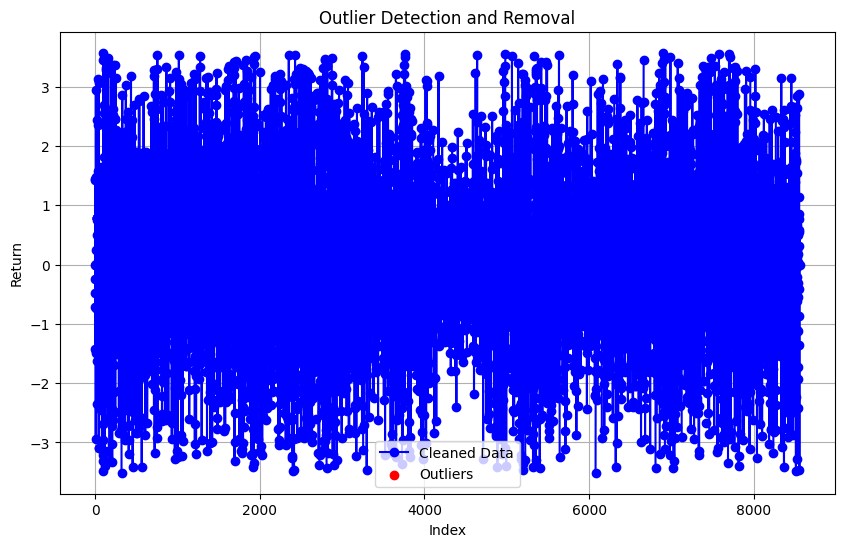

Outliers removed and replaced with interpolated values.
Training on first 8128 observations.
Testing on remaining 428 observations.


In [3]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v2"
os.chdir(project_dir)
data_dir = os.path.join(project_dir, "raw_data/single_names")
    
# 1. Load data and preprocess
stock_name = "EQNR"
file_path = os.path.join(data_dir, f"{stock_name}_Close.csv")
df = pd.read_csv(file_path, sep=";", decimal=",")
result = generate_log_ts(df)
ts_ret = result["ts"]
df_full_ret = result["df_full_ret"]

diff_result = check_differencing(df_full_ret)

d = diff_result["normal_diff_order"]
seasonal_diff_order_monthly = diff_result["seasonal_diff_order_monthly"]
seasonal_diff_order_yearly =  diff_result["seasonal_diff_order_yearly"]

df_wo_outliers = remove_outliers(df_full_ret)

# Intermediate step: divide between train and test
ts_ret = df_wo_outliers["Return"].values
train_size = 0.95
n = len(ts_ret)
train_index = int(train_size * n)
ts_train = ts_ret[:train_index]
ts_test = ts_ret[train_index:]
print(f"Training on first {len(ts_train)} observations.")
print(f"Testing on remaining {len(ts_test)} observations.")

In [4]:
def choose_best_garch(ts, max_p, max_r, max_s, threshold=0.01, verbose=False):
    """
    Choose the best GARCH(p, q) model based on the number of verified hypotheses and AIC.

    Returns:
        best_model: The best GARCH model object.
        results_df: A DataFrame with all models and their diagnostics.
        best_r: The ARCH order of the best model.
        best_s: The GARCH order of the best model.
    """
    results = []
    
    for r in range(max_r + 1):
        for s in range(max_s + 1):
            for ar_p in range(max_p + 1):
                try:
                    # Fit the GARCH model
                    garch_model = arch_model(ts, vol="EGarch", p=r, q=s, mean="ARX", lags=ar_p, dist="t").fit(disp="off")
                    
                    # Proportion significant
                    p_values = garch_model.pvalues
                    prop = np.mean(p_values <= 0.05)
                    
                    # Collect residuals and conditional volatility
                    residuals = garch_model.std_resid
                    residuals = residuals[~np.isnan(residuals)]
                    fitted_values = garch_model.conditional_volatility
                    fitted_values = fitted_values[~np.isnan(fitted_values)]

                    # Perform diagnostics
                    ljungbox_pvalue = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
                    lilliefors_stat, lilliefors_pvalue = lilliefors(residuals)

                    # Check for homoscedasticity
                    if fitted_values is not None:
                        aux_data = pd.DataFrame({
                            "residuals_squared": residuals**2,
                            "fitted_values": fitted_values
                        }).dropna()
                        bp_test_stat, bp_pvalue, _, _ = het_breuschpagan(aux_data["residuals_squared"], add_constant(aux_data["fitted_values"]))
                    else:
                        bp_pvalue = np.nan
                    
                    print(f"Executing for {r}, {s}, {ar_p}, normality: {lilliefors_pvalue}, independence: {ljungbox_pvalue}, homoscedasticity: {bp_pvalue}")
                    
                    # Count verified hypotheses
                    verified_hypotheses = sum([
                        lilliefors_pvalue > threshold,  # Normality
                        ljungbox_pvalue > threshold,  # Independence
                        bp_pvalue > threshold  # Homoscedasticity
                    ])

                    # Append model results
                    results.append({
                        "Model": f"AR({ar_p})-GARCH({r},{s})",
                        "Verified_Hypotheses": verified_hypotheses,
                        "Proportion_significant": prop,
                        "Normality_pvalue": lilliefors_pvalue,
                        "Independence_pvalue": ljungbox_pvalue,
                        "Homoscedasticity_pvalue": bp_pvalue,
                        "p": ar_p,
                        "r": r,
                        "s": s,
                        "GARCH_Object": garch_model
                    })

                    if verbose:
                        print(f"AR {ar_p} - GARCH({r},{s}) verified: {verified_hypotheses}")
                except Exception as e:
                    if verbose:
                        print(f"Error fitting AR({ar_p})-GARCH({r},{s}): {e}")
                    continue

    # Convert results to a DataFrame
    if results:
        results_df = pd.DataFrame(results)

        # Sort by verified hypotheses, then by AIC
        results_df = results_df.sort_values(
            by=["Verified_Hypotheses", "Proportion_significant"], ascending=[False, True]
        )

        # Select the best model
        if not results_df.empty:
            best_row = results_df.iloc[0]
            best_model = best_row["GARCH_Object"]
            best_p, best_r, best_s = best_row["p"], best_row["r"], best_row["s"]
            if verbose:
                print(f"Best Model: {best_row['Model']} with {best_row['Verified_Hypotheses']} verified hypotheses and AIC={best_row['AIC']:.2f}")
            return best_model, results_df, best_r, best_s

    # If no valid models
    return None, pd.DataFrame(), None, None


In [55]:
def choose_best_garch_arima(ts, max_p, max_q, max_r, max_s, d=0, threshold=0.01, verbose=False):
    """
    Choose the best GARCH(p, q) model based on the number of verified hypotheses and AIC.

    Returns:
        best_model: The best GARCH model object.
        results_df: A DataFrame with all models and their diagnostics.
        best_r: The ARCH order of the best model.
        best_s: The GARCH order of the best model.
    """
    results = []
    
    for r in range(1, max_r + 1):
        for s in range(1, max_s + 1):
            for ar_p in range(1, max_p + 1):
                for ar_q in range(1, max_q + 1):
                    try:
                        print(f"{ar_p}, {ar_q}, {r}, {s}")
                        arma_model = ARIMA(ts, order=(ar_p, d, ar_q)).fit()
                        arma_residuals = arma_model.resid
                        
                        # Fit the GARCH model
                        garch_model = arch_model(
                            arma_residuals, vol="Garch", p=r, q=s, mean="Zero", dist="ged"
                        ).fit(disp="off")  # Use mean="Zero" as residuals are already from the ARIMA model

                        # Proportion significant
                        p_values = garch_model.pvalues
                        prop = np.mean(p_values <= 0.05)

                        # Collect residuals and conditional volatility
                        residuals = garch_model.std_resid
                        residuals = residuals[~np.isnan(residuals)]
                        fitted_values = garch_model.conditional_volatility
                        fitted_values = fitted_values[~np.isnan(fitted_values)]

                        # Perform diagnostics
                        ljungbox_pvalue = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
                        lilliefors_stat, lilliefors_pvalue = lilliefors(residuals)

                        # Check for homoscedasticity
                        if fitted_values is not None:
                            aux_data = pd.DataFrame({
                                "residuals_squared": residuals**2,
                                "fitted_values": fitted_values
                            }).dropna()
                            bp_test_stat, bp_pvalue, _, _ = het_breuschpagan(aux_data["residuals_squared"], add_constant(aux_data["fitted_values"]))
                        else:
                            bp_pvalue = np.nan

                        print(f"Executing for {r}, {s}, {ar_p}, normality: {lilliefors_pvalue}, independence: {ljungbox_pvalue}, homoscedasticity: {bp_pvalue}")

                        # Count verified hypotheses
                        verified_hypotheses = sum([
                            lilliefors_pvalue > threshold,  # Normality
                            ljungbox_pvalue > threshold,  # Independence
                            bp_pvalue > threshold  # Homoscedasticity
                        ])

                        # Append model results
                        results.append({
                            "Model": f"AR({ar_p}, {ar_q})-GARCH({r},{s})",
                            "Verified_Hypotheses": verified_hypotheses,
                            "Proportion_significant": prop,
                            "Normality_pvalue": lilliefors_pvalue,
                            "Independence_pvalue": ljungbox_pvalue,
                            "Homoscedasticity_pvalue": bp_pvalue,
                            "p": ar_p,
                            "r": r,
                            "s": s,
                            "GARCH_Object": garch_model
                        })

                    except Exception as e:
                        if verbose:
                            print(f"Error fitting AR({ar_p})-GARCH({r},{s}): {e}")
                        continue
    results_df = pd.DataFrame(results)

    # Sort by verified hypotheses, then by AIC
    results_df = results_df.sort_values(
       by=["Verified_Hypotheses", "Proportion_significant"], ascending=[False, False])

    # Select the best model
    if not results_df.empty:
        best_row = results_df.iloc[0]
        best_model = best_row["GARCH_Object"]
        best_p, best_r, best_s = best_row["p"], best_row["r"], best_row["s"]
        if verbose:
            print(f"Best Model: {best_row['Model']} with {best_row['Verified_Hypotheses']}")
        return best_model, results_df, best_r, best_s
    else:
        return results


In [56]:
hola = choose_best_garch_arima(ts_ret, 3, 3, 3, 3, d=0, threshold=0.01, verbose=True)

1, 1, 1, 1
Executing for 1, 1, 1, normality: 0.0009999999999998899, independence: 8.478516598754215e-09, homoscedasticity: 1.1799753878970435e-15
1, 2, 1, 1
Executing for 1, 1, 1, normality: 0.0009999999999998899, independence: 0.0002287344448506994, homoscedasticity: 9.449280372382638e-16
1, 3, 1, 1
Executing for 1, 1, 1, normality: 0.0009999999999998899, independence: 0.0705665453927195, homoscedasticity: 8.81544590592636e-16
2, 1, 1, 1


/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 1, 1, 2, normality: 0.0009999999999998899, independence: 0.0051523936312790385, homoscedasticity: 1.0044726011748196e-15
2, 2, 1, 1
Executing for 1, 1, 2, normality: 0.0009999999999998899, independence: 0.006284176399218878, homoscedasticity: 8.048746806691652e-16
2, 3, 1, 1
Executing for 1, 1, 2, normality: 0.0009999999999998899, independence: 0.08287215679671353, homoscedasticity: 8.462928052776682e-16
3, 1, 1, 1
Executing for 1, 1, 3, normality: 0.0009999999999998899, independence: 0.023283129258465315, homoscedasticity: 7.414894632893883e-16
3, 2, 1, 1
Executing for 1, 1, 3, normality: 0.0009999999999998899, independence: 0.028015364846207765, homoscedasticity: 7.272394595010668e-16
3, 3, 1, 1
Executing for 1, 1, 3, normality: 0.0009999999999998899, independence: 0.08998015509812378, homoscedasticity: 8.338106322316222e-16
1, 1, 1, 2
Executing for 1, 2, 1, normality: 0.0009999999999998899, independence: 8.478311592533871e-09, homoscedasticity: 1.179983957263278e-15
1,

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 1, 2, 2, normality: 0.0009999999999998899, independence: 0.005152420624156093, homoscedasticity: 1.0042386217006778e-15
2, 2, 1, 2
Executing for 1, 2, 2, normality: 0.0009999999999998899, independence: 0.006283826927798878, homoscedasticity: 8.046476030557242e-16
2, 3, 1, 2
Executing for 1, 2, 2, normality: 0.0009999999999998899, independence: 0.08286984419965415, homoscedasticity: 8.459746353820393e-16
3, 1, 1, 2
Executing for 1, 2, 3, normality: 0.0009999999999998899, independence: 0.023282160610572183, homoscedasticity: 7.411814104023235e-16
3, 2, 1, 2
Executing for 1, 2, 3, normality: 0.0009999999999998899, independence: 0.028014152074717687, homoscedasticity: 7.268891496503495e-16
3, 3, 1, 2
Executing for 1, 2, 3, normality: 0.0009999999999998899, independence: 0.08997791470416909, homoscedasticity: 8.335269169246721e-16
1, 1, 1, 3
Executing for 1, 3, 1, normality: 0.0009999999999998899, independence: 4.645180613792731e-05, homoscedasticity: 5.42924342140158e-15
1, 2

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 1, 3, 2, normality: 0.0009999999999998899, independence: 0.0051525320566512866, homoscedasticity: 1.0048178603711096e-15
2, 2, 1, 3
Executing for 1, 3, 2, normality: 0.0009999999999998899, independence: 0.006283774428715368, homoscedasticity: 8.045990843551058e-16
2, 3, 1, 3
Executing for 1, 3, 2, normality: 0.0009999999999998899, independence: 0.08287164480705185, homoscedasticity: 8.461284108805672e-16
3, 1, 1, 3
Executing for 1, 3, 3, normality: 0.0009999999999998899, independence: 0.023283970945967666, homoscedasticity: 7.422241781089271e-16
3, 2, 1, 3
Executing for 1, 3, 3, normality: 0.0009999999999998899, independence: 0.02801558885158897, homoscedasticity: 7.273920945253822e-16
3, 3, 1, 3
Executing for 1, 3, 3, normality: 0.0009999999999998899, independence: 0.08998355993422413, homoscedasticity: 8.346230808744026e-16
1, 1, 2, 1
Executing for 2, 1, 1, normality: 0.0009999999999998899, independence: 0.00022418295722709486, homoscedasticity: 3.8126193929674505e-09
1

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 2, 1, 2, normality: 0.0009999999999998899, independence: 0.04659481670517952, homoscedasticity: 4.169094385624799e-09
2, 2, 2, 1
Executing for 2, 1, 2, normality: 0.0009999999999998899, independence: 0.3799012946135527, homoscedasticity: 3.4947792256997972e-09
2, 3, 2, 1
Executing for 2, 1, 2, normality: 0.0009999999999998899, independence: 0.7021058161470506, homoscedasticity: 3.393958626676318e-09
3, 1, 2, 1
Executing for 2, 1, 3, normality: 0.0009999999999998899, independence: 0.40452506891517653, homoscedasticity: 3.606931071862453e-09
3, 2, 2, 1
Executing for 2, 1, 3, normality: 0.0009999999999998899, independence: 0.3952958019374635, homoscedasticity: 3.527523207466103e-09
3, 3, 2, 1
Executing for 2, 1, 3, normality: 0.0009999999999998899, independence: 0.7267454305093697, homoscedasticity: 3.3659833433019255e-09
1, 1, 2, 2
Executing for 2, 2, 1, normality: 0.0009999999999998899, independence: 8.383584760499217e-09, homoscedasticity: 1.1647572478326772e-15
1, 2, 2, 

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 2, 2, 2, normality: 0.0009999999999998899, independence: 0.005149902337613801, homoscedasticity: 9.846253232541282e-16
2, 2, 2, 2
Executing for 2, 2, 2, normality: 0.0009999999999998899, independence: 0.006397779552706761, homoscedasticity: 7.789402822819555e-16
2, 3, 2, 2
Executing for 2, 2, 2, normality: 0.0009999999999998899, independence: 0.08378634247919708, homoscedasticity: 8.221774993817595e-16
3, 1, 2, 2
Executing for 2, 2, 3, normality: 0.0009999999999998899, independence: 0.02369056997935521, homoscedasticity: 7.18845997400427e-16
3, 2, 2, 2
Executing for 2, 2, 3, normality: 0.0009999999999998899, independence: 0.028480986798146198, homoscedasticity: 7.0326798722172365e-16
3, 3, 2, 2
Executing for 2, 2, 3, normality: 0.0009999999999998899, independence: 0.09098026470001554, homoscedasticity: 8.100937814467171e-16
1, 1, 2, 3
Executing for 2, 3, 1, normality: 0.0009999999999998899, independence: 4.647156090363476e-05, homoscedasticity: 5.414988061339157e-15
1, 2,

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 2, 3, 2, normality: 0.0009999999999998899, independence: 0.005149936966078806, homoscedasticity: 9.846251591092883e-16
2, 2, 2, 3
Executing for 2, 3, 2, normality: 0.0009999999999998899, independence: 0.006398149572624095, homoscedasticity: 7.789649496392761e-16
2, 3, 2, 3
Executing for 2, 3, 2, normality: 0.0009999999999998899, independence: 0.08377907242765523, homoscedasticity: 8.217601924803846e-16
3, 1, 2, 3
Executing for 2, 3, 3, normality: 0.0009999999999998899, independence: 0.023685220925377178, homoscedasticity: 7.155562881320228e-16
3, 2, 2, 3
Executing for 2, 3, 3, normality: 0.0009999999999998899, independence: 0.028480116874275024, homoscedasticity: 7.029767184735459e-16
3, 3, 2, 3
Executing for 2, 3, 3, normality: 0.0009999999999998899, independence: 0.09097691644691054, homoscedasticity: 8.097361240235714e-16
1, 1, 3, 1
Executing for 3, 1, 1, normality: 0.0009999999999998899, independence: 0.0002242044670653239, homoscedasticity: 3.785652484004265e-09
1, 2

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 3, 1, 2, normality: 0.0009999999999998899, independence: 0.046607530458339146, homoscedasticity: 4.201266289995076e-09
2, 2, 3, 1
Executing for 3, 1, 2, normality: 0.0009999999999998899, independence: 0.3799082118913486, homoscedasticity: 3.4989887201029218e-09
2, 3, 3, 1
Executing for 3, 1, 2, normality: 0.0009999999999998899, independence: 0.701998647099881, homoscedasticity: 3.356526106462993e-09
3, 1, 3, 1
Executing for 3, 1, 3, normality: 0.0009999999999998899, independence: 0.4042897698803785, homoscedasticity: 3.5314345011973314e-09
3, 2, 3, 1
Executing for 3, 1, 3, normality: 0.0009999999999998899, independence: 0.39529161483130615, homoscedasticity: 3.5267157383207676e-09
3, 3, 3, 1
Executing for 3, 1, 3, normality: 0.0009999999999998899, independence: 0.7267453766174418, homoscedasticity: 3.365809430722421e-09
1, 1, 3, 2
Executing for 3, 2, 1, normality: 0.0009999999999998899, independence: 8.382695148457815e-09, homoscedasticity: 1.164133967475482e-15
1, 2, 3, 

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 3, 2, 2, normality: 0.0009999999999998899, independence: 0.005149945104619798, homoscedasticity: 9.847013394273932e-16
2, 2, 3, 2
Executing for 3, 2, 2, normality: 0.0009999999999998899, independence: 0.006398020151338695, homoscedasticity: 7.789009090538149e-16
2, 3, 3, 2
Executing for 3, 2, 2, normality: 0.0009999999999998899, independence: 0.083786930842639, homoscedasticity: 8.22969536975929e-16
3, 1, 3, 2
Executing for 3, 2, 3, normality: 0.0009999999999998899, independence: 0.023687532989085776, homoscedasticity: 7.167390331338938e-16
3, 2, 3, 2
Executing for 3, 2, 3, normality: 0.0009999999999998899, independence: 0.02847120893092733, homoscedasticity: 7.013192940980975e-16
3, 3, 3, 2
Executing for 3, 2, 3, normality: 0.0009999999999998899, independence: 0.09099044611032177, homoscedasticity: 8.128478659713439e-16
1, 1, 3, 3
Executing for 3, 3, 1, normality: 0.0009999999999998899, independence: 4.646846869654008e-05, homoscedasticity: 5.421096279864924e-15
1, 2, 3,

/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jupyter-tfg2425paula/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Executing for 3, 3, 2, normality: 0.0009999999999998899, independence: 0.005149966056338044, homoscedasticity: 9.849896891097591e-16
2, 2, 3, 3
Executing for 3, 3, 2, normality: 0.0009999999999998899, independence: 0.006398031610054899, homoscedasticity: 7.7831702769909285e-16
2, 3, 3, 3
Executing for 3, 3, 2, normality: 0.0009999999999998899, independence: 0.08378799793855166, homoscedasticity: 8.21694927228782e-16
3, 1, 3, 3
Executing for 3, 3, 3, normality: 0.0009999999999998899, independence: 0.023669579904169343, homoscedasticity: 7.171170632368782e-16
3, 2, 3, 3
Executing for 3, 3, 3, normality: 0.0009999999999998899, independence: 0.028474755607001655, homoscedasticity: 7.020281880058429e-16
3, 3, 3, 3
Executing for 3, 3, 3, normality: 0.0009999999999998899, independence: 0.09098274598957863, homoscedasticity: 8.100683927862764e-16
Best Model: AR(1, 2)-GARCH(1,3) with 1


In [18]:
arma_model = ARIMA(ts_ret, order=(1, 0, 1)).fit()
arma_residuals = arma_model.resid

In [59]:
best_model, results_df, best_r, best_s = hola

In [60]:
results_df

,Model,Verified_Hypotheses,Proportion_significant,Normality_pvalue,Independence_pvalue,Homoscedasticity_pvalue,p,r,s,GARCH_Object
19,"AR(1, 2)-GARCH(1,3)",1,0.166667,0.001,6.885047e-02,1.804296e-15,1,1,3,Zero Mean - GARCH...
73,"AR(1, 2)-GARCH(3,3)",1,0.375000,0.001,6.888609e-02,1.797827e-15,1,3,3,Zero Mean - GARCH...
74,"AR(1, 3)-GARCH(3,3)",1,0.375000,0.001,7.134304e-02,8.563322e-16,1,3,3,Zero Mean - GARCH...
77,"AR(2, 3)-GARCH(3,3)",1,0.375000,0.001,8.378800e-02,8.216949e-16,2,3,3,Zero Mean - GARCH...
78,"AR(3, 1)-GARCH(3,3)",1,0.375000,0.001,2.366958e-02,7.171171e-16,3,3,3,Zero Mean - GARCH...
...,...,...,...,...,...,...,...,...,...,...
27,"AR(1, 1)-GARCH(2,1)",0,0.600000,0.001,2.241830e-04,3.812619e-09,1,2,1,Zero Mean - GARCH...
0,"AR(1, 1)-GARCH(1,1)",0,0.750000,0.001,8.478517e-09,1.179975e-15,1,1,1,Zero Mean - GARCH...
1,"AR(1, 2)-GARCH(1,1)",0,0.750000,0.001,2.287344e-04,9.449280e-16,1,1,1,Zero Mean - GARCH...
3,"AR(2, 1)-GARCH(1,1)",0,0.750000,0.001,5.152394e-03,1.004473e-15,2,1,1,Zero Mean - GARCH...
